# CASA0013: Foundations of Spatial Data Science

## Reproducible Analysis

### Student ID: 21047001


### 1. Import packages 


In [170]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### 2. Load London MSOAs Data


#### 2.1. Load MSOA data shapefile

<AxesSubplot:>

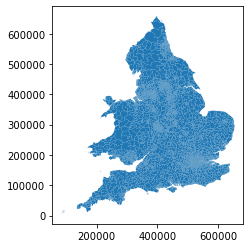

In [2]:
msoas = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V3-shp.zip?raw=true')
# MSOA geopackage source link: 
# https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-boundaries-full-extent-bfe-ew-v3/

msoas.plot()

In [3]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
5349,5350,E02005475,South Holland 011,South Holland 011,525564,311283,-0.14388,52.68471,7.249070e+07,54097.876625,"POLYGON ((527566.585 319997.945, 527571.560 31..."
5362,5363,E02005488,South Kesteven 013,South Kesteven 013,513130,311041,-0.32782,52.68527,1.274947e+07,25445.784756,"POLYGON ((516746.279 313420.148, 517192.093 31..."
5243,5244,E02005363,Charnwood 019,Charnwood 019,459440,311203,-1.12192,52.69527,6.120551e+06,16854.843686,"POLYGON ((459725.906 311953.813, 459875.814 31..."


In [4]:
for gpkg in [msoas]:
    print(gpkg.crs)

epsg:27700


#### 2.2. Set London Brough Boundaries

In [45]:
boros = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Boroughs.gpkg?raw=true')
# Borough geopackage source link: 
# https://data.london.gov.uk/dataset/london_boroughs

# boros.plot()
boros.shape

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(33, 6)

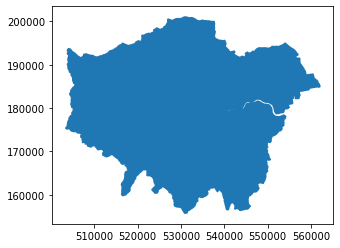

In [6]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# The boundary is buffered by 250m in order to ensure all MSOAs _within_ London can be ontained 

ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

#### 2.3. Set London MSOAs

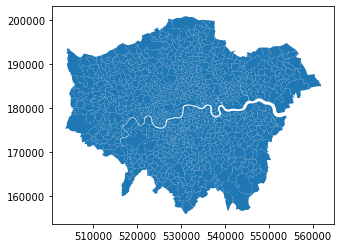

In [7]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

In [8]:
# del(msoas)

#### 2.4. Extract Borough Names

In [38]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r' \d+$','',regex=True)

print(ldn_msoas.Borough.unique())
print(len(ldn_msoas.Borough.unique()))
print(ldn_msoas.shape)
ldn_msoas

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
33
(983, 14)


,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,index_right,original,Borough
0,1,E02000001,City of London 001,City of London 001,532384,181355,-0.093490,51.51561,2.906361e+06,8936.818478,"POLYGON ((532135.138 182198.131, 532158.250 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",City of London
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,"POLYGON ((548881.563 190845.265, 548881.125 19...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Barking and Dagenham
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,"POLYGON ((549102.438 189324.625, 548954.517 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Barking and Dagenham
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,"POLYGON ((551550.056 187364.705, 551478.000 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Barking and Dagenham
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,"POLYGON ((549099.634 187656.076, 549161.375 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Barking and Dagenham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,6784,E02006927,Greenwich 034,Greenwich 034,540765,175168,0.024750,51.45799,2.526112e+06,8592.913078,"POLYGON ((541029.881 176265.023, 541101.997 17...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Greenwich
6784,6785,E02006928,Greenwich 035,Greenwich 035,537902,177443,-0.015540,51.47914,5.405753e+05,6849.063388,"MULTIPOLYGON (((538300.370 177956.634, 538290....",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Greenwich
6785,6786,E02006929,Greenwich 036,Greenwich 036,540015,179091,0.015515,51.49343,2.550052e+06,13109.533457,"POLYGON ((540054.362 179353.134, 540220.354 17...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Greenwich
6786,6787,E02006930,Greenwich 037,Greenwich 037,540126,178333,0.016812,51.48659,8.679553e+05,7492.395145,"POLYGON ((539552.478 178604.042, 539533.000 17...",0,"POLYGON ((534747.800 159517.800, 534588.000 15...",Greenwich


#### 2.5.  Add MSOA names using a merge

In [10]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')
# MSOAs names data source link:
# https://houseofcommonslibrary.github.io/msoanames/

print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)


['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02005951,Oxford 012,Oxford 012,Grandpont & New Hinksey,NaN,Oxford
4660,W02000113,Powys 017,Powys 017,Brecon,Aberhonddu,Powys
1038,W02000309,Caerphilly 020,Caerffili 020,Bedwas & Trethomas,Bedwas a Thretomas,Caerphilly


In [11]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(983, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
810,811,E02000841,Sutton 002,St Helier South
801,802,E02000832,Southwark 026,Nunhead North
813,814,E02000844,Sutton 005,The Wrythe


In [12]:
# tidy the data

to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)
msoas

(983, 8)


,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,geometry,Borough,msoa11hclnm
0,1,E02000001,City of London 001,532384,181355,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London,City of London
1,2,E02000002,Barking and Dagenham 001,548267,189685,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham,Marks Gate
2,3,E02000003,Barking and Dagenham 002,548259,188520,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham,Chadwell Heath East
3,4,E02000004,Barking and Dagenham 003,551004,186412,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham,Eastbrookend
4,5,E02000005,Barking and Dagenham 004,548733,186824,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham,Becontree Heath
...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,540765,175168,"POLYGON ((541029.881 176265.023, 541101.997 17...",Greenwich,Kidbrooke South
979,6785,E02006928,Greenwich 035,537902,177443,"MULTIPOLYGON (((538300.370 177956.634, 538290....",Greenwich,Greenwich & Deptford Creekside
980,6786,E02006929,Greenwich 036,540015,179091,"POLYGON ((540054.362 179353.134, 540220.354 17...",Greenwich,Greenwich Peninsula
981,6787,E02006930,Greenwich 037,540126,178333,"POLYGON ((539552.478 178604.042, 539533.000 17...",Greenwich,Greenwich East


### 3. Load Cultural Infrastructure Data

#### 3.1. Load cultural infrastructure (culin) csv data

In [13]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/cultural_infrastructure_all_sites.csv'
# Cultural infrastructure data source link: 
# https://data.london.gov.uk/dataset/cultural-infrastructure-map

df_culin = pd.read_csv(url, low_memory=False)
df_culin.shape

(10003, 29)

In [197]:
# Clean the data
df_culin.drop(df_culin[((df_culin.latitude.isna())|(df_culin.longitude.isna()))].index, axis=0, inplace=True)
df_culin.drop(df_culin[((df_culin.latitude < 40)|(df_culin.longitude > 1))].index, axis=0, inplace=True)
df_culin.shape

(10003, 30)

In [15]:
df_culin.columns

Index(['BOROUGH', 'Cultural Venue Type', 'additional_contact_name', 'address1',
       'address2', 'address3', 'alternativenames', 'borough_code',
       'borough_name', 'building_name', 'contact_name', 'easting',
       'fid_london_ward', 'greenflagcommunityaward', 'gss_code', 'latitude',
       'longitude', 'northing', 'os_addressbase_uprn', 'rm_organisation_name',
       'runtime', 'site_name', 'ward', 'ward_2018_code', 'ward_2018_name',
       'ward_code', 'ward_code_2018', 'ward_name_2018', 'website'],
      dtype='object')

#### 3.2. Convert the dataframe into a GeoDataFrame(gdf)

<AxesSubplot:>

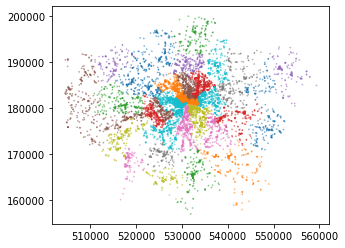

In [16]:
gdf_culin = gpd.GeoDataFrame(df_culin, geometry=gpd.points_from_xy(df_culin.longitude, df_culin.latitude,
                                                       crs='epsg:4326'))
gdf_culin = gdf_culin.to_crs('epsg:27700')
gdf_culin.plot(column='BOROUGH', markersize=0.5, alpha=0.5)

#### 3.3. Check problematic listings

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

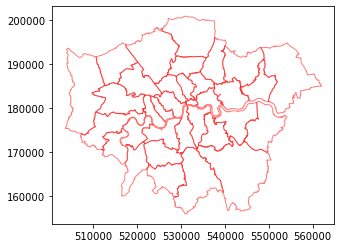

In [17]:
ax = gdf_culin[gdf_culin.BOROUGH.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

#### 3.4. Check results

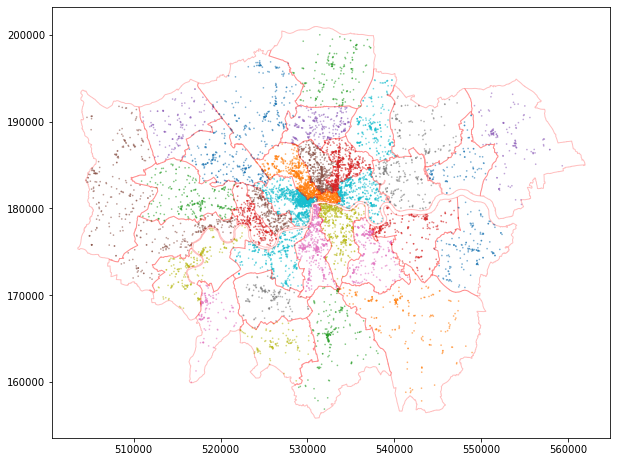

In [18]:
ax = gdf_culin.plot(column='BOROUGH', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.25);


### 4. Load Inside Airbnb Data


#### 4.1. Load Inside Airbnb listings data

In [47]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/2021-10-10-listings.csv'
I
http://insideairbnb.com/get-the-data.html

cols = ['id','name','price','latitude','longitude','room_type']

df_airbnb = pd.read_csv(url, usecols=cols, low_memory=False)
df_airbnb.shape
# df_airbnb.columns
# df_airbnb.sample(3)

(67903, 6)

In [48]:
# clean the data

df_airbnb['price'] = df_airbnb.price.astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)
print(df_airbnb.shape)

(67903, 6)


#### 4.2. Convert the dataframe into a GeoDataFrame

In [49]:
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude,
                                                       crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

#### 4.3.  Add Local Authority Names to Data
Associate Local Authority (LA) names to the listings using a spatial join:

In [50]:
gdf_la = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'room_type' 'price' 'geometry'
 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [51]:
print(gdf_la.shape)
gdf_la.sample(3)

(67903, 13)


,id,name,latitude,longitude,room_type,price,geometry,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER
59782,47951960,Modern Studio in King's Cross,51.53229,-0.11814,Entire home/apt,1570.0,POINT (530627.923 183165.142),27.0,Islington,E09000019,1485.664,0.000,T
35849,28599858,Lovely light loft room & bathroom in Islington,51.56086,-0.10022,Private room,65.0,POINT (531788.290 186374.352),27.0,Islington,E09000019,1485.664,0.000,T
11888,11606785,Double Room near Limehouse E14,51.51373,-0.03384,Private room,22.0,POINT (536530.171 181254.986),26.0,Tower Hamlets,E09000030,2157.501,179.707,T


#### 4.4. Tidy up

In [52]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Wandsworth', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Croydon', 'Southwark',
       'Waltham Forest', 'Brent', 'Camden', 'Newham', 'Tower Hamlets',
       'Lambeth', 'Hackney', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Ealing', 'Enfield', 'City of London',
       'Barking and Dagenham', 'Hillingdon', 'Harrow', 'Redbridge',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

#### 4.5. Map problematic listings

<AxesSubplot:>

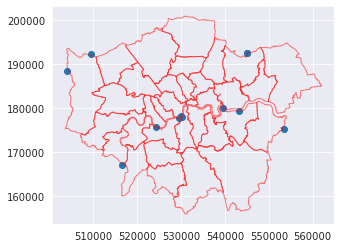

In [53]:
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

#### 4.6. Drop problematic listings

In [54]:
gdf_la.drop(index=gdf_airbnb[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(67891, 9)


,id,name,latitude,longitude,room_type,price,geometry,NAME,GSS_CODE
0,13913,Holiday London DB Room Let-on going,51.568610,-0.112700,Private room,65.0,POINT (530901.013 187213.787),Islington,E09000019
1,15400,Bright Chelsea Apartment. Chelsea!,51.487800,-0.168130,Entire home/apt,75.0,POINT (527284.576 178129.679),Kensington and Chelsea,E09000020
2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.521950,-0.140940,Entire home/apt,307.0,POINT (529075.790 181974.865),Westminster,E09000033
3,17506,Boutique Chelsea/Fulham Double bed 5-star ensuite,51.479350,-0.197430,Private room,150.0,POINT (525273.544 177139.513),Hammersmith and Fulham,E09000013
4,24328,"Battersea bedroom & studio, parking, shared ga...",51.471190,-0.162560,Entire home/apt,200.0,POINT (527717.629 176292.280),Wandsworth,E09000032
...,...,...,...,...,...,...,...,...,...
67897,52705071,Spacious East London apartment (with balcony!),51.550890,0.024820,Entire home/apt,75.0,POINT (540485.894 185498.224),Newham,E09000025
67898,52708661,Immaculate room available,51.401175,-0.103159,Private room,30.0,POINT (532044.631 168611.718),Croydon,E09000008
67899,52710377,Double studio apartment in Lancaster Gate (14,51.511012,-0.180414,Entire home/apt,72.0,POINT (526367.580 180689.713),Westminster,E09000033
67900,52711482,4 Bedroom House in The Tonsleys (Wandsworth Town),51.459225,-0.183314,Entire home/apt,400.0,POINT (526309.287 174925.775),Wandsworth,E09000032


#### 4.7. Check results

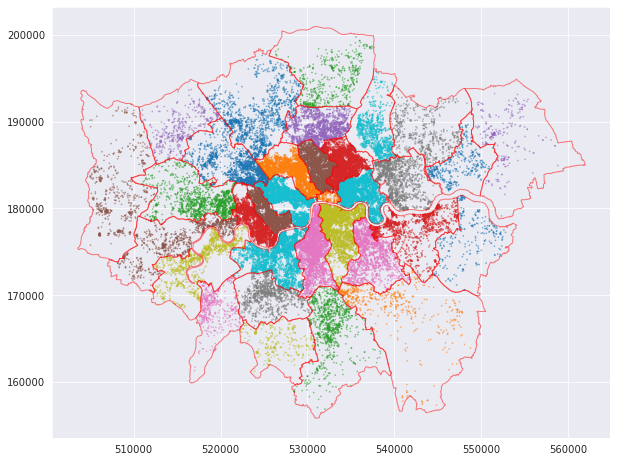

In [55]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);


### 5. Explore Airbnb Price for Each Borough

#### 5.1. Calculate median price

In [120]:
la_airbnb_price = gdf_la.groupby('NAME').agg({'price':['median']}).reset_index()
# median price of airbnb for each borough

In [121]:
# Fix the missing column name:
la_airbnb_price.columns = la_airbnb_price.columns.get_level_values(0)
la_airbnb_price.rename(columns={'':'NAME', 'price':'price_median'}, inplace=True)
la_airbnb_price.head()

,NAME,price_median
0,Barking and Dagenham,49.5
1,Barnet,61.0
2,Bexley,45.0
3,Brent,69.0
4,Bromley,55.0


In [122]:
price_data = boros.set_index('NAME').join(la_airbnb_price.set_index('NAME'))
price_data.head()

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,price_median
NAME,,,,,,
Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",64.0
Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005....",45.0
Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361....",55.0
Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",60.0
Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249....",55.0


#### 5.2. Plot the median price

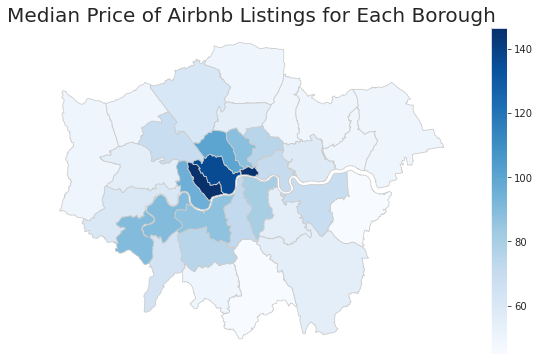

In [130]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'price_median'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10,6))

price_data.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.axis('off') # remove the axis

ax.set_title('Median Price of Airbnb Listings for Each Borough', fontdict={'fontsize': '20', 'fontweight' : '3'}) # add a title

fig.savefig('median_price.png', dpi=300)

# Reference source for plotting:
# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

Text(0.5, 1.0, 'Colors vs Values')

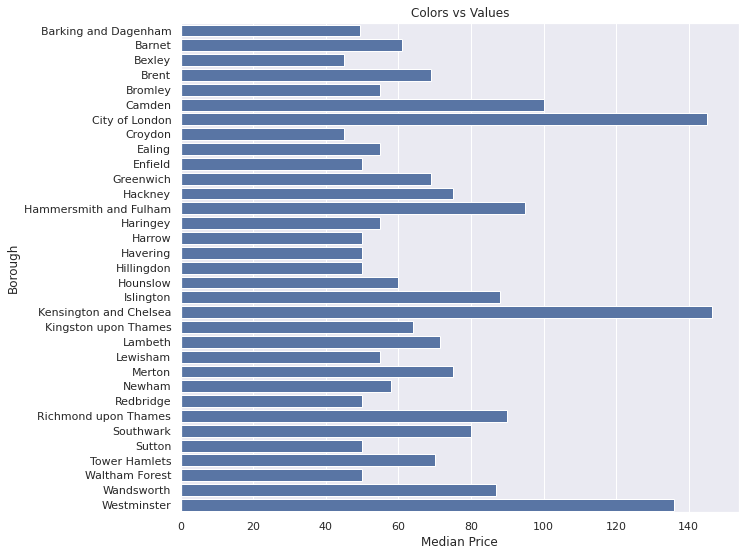

In [145]:

# ax = sns.displot((la_airbnb_price.price.median() - la_airbnb_price.price.median().median())/la_airbnb_price.price.std())
# ax.set(xlabel='Standardised Price', ylabel='Number of Boroughs')
# plt.gcf().subplots_adjust(top=0.9)
# plt.gcf().suptitle('Standardised Mean Price', fontsize=15, fontweight='bold');

# la_airbnb_price = pd.DataFrame({'cat': ['red', 'green', 'blue'], 'val': [1, 2, 3]})
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,9)})
sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(x = 'price_median', y = 'NAME', data = la_airbnb_price, color = 'b')
plt.xlabel("Median Price")
plt.ylabel("Borough")
plt.title("Colors vs Values")



### 6. Exploring a Certain Local Authority

#### 6.1. Select an LA for exploring 

In [185]:
LA = 'Camden'

#### 6.2. Spatial Join Airbnb Listings and MSOAs

In [186]:
msoadf  = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            msoas[msoas.Borough==LA], op='within')
msoadf.head()

,index,id,name,latitude,longitude,room_type,price,geometry,NAME,GSS_CODE,index_right,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm
0,27,45163,Room with a garden,51.55237,-0.19954,Private room,45.0,POINT (524927.254 185256.066),Camden,E09000007,164,165,E02000170,Camden 005,524736,185497,Camden,Fortune Green
42,729,528124,Large bright dbl rm w-hampstead-1,51.55654,-0.19500,Private room,46.0,POINT (525230.556 185727.548),Camden,E09000007,164,165,E02000170,Camden 005,524736,185497,Camden,Fortune Green
90,1408,1013117,"Central, Camden, Hampstead Dbl Room, Bath & Lo...",51.55211,-0.20361,Private room,60.0,POINT (524645.801 185220.215),Camden,E09000007,164,165,E02000170,Camden 005,524736,185497,Camden,Fortune Green
111,1612,1270251,Large bright dbl rm w-hampstead-2,51.55632,-0.19703,Private room,46.0,POINT (525090.438 185699.612),Camden,E09000007,164,165,E02000170,Camden 005,524736,185497,Camden,Fortune Green
114,1659,1339785,Fab Flat 15 Min Cntrl Lon,51.55611,-0.21064,Entire home/apt,150.0,POINT (524147.544 185653.090),Camden,E09000007,164,165,E02000170,Camden 005,524736,185497,Camden,Fortune Green


#### 6.3. Aggregate by MSOA

In [187]:
msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()

In [188]:
msoagrdf.columns = msoagrdf.columns.get_level_values(1)
msoagrdf.head()

,,median,count
0,Camden 001,98.0,73
1,Camden 002,110.5,98
2,Camden 003,100.0,105
3,Camden 004,122.5,90
4,Camden 005,92.5,80


In [189]:
# Fix the missing column name:
msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)
msoagrdf.head()

,MSOA11NM,median,listings
0,Camden 001,98.0,73
1,Camden 002,110.5,98
2,Camden 003,100.0,105
3,Camden 004,122.5,90
4,Camden 005,92.5,80


#### 6.4. Join on Indexes

In [190]:
msoa_gdf = msoagrdf.set_index('MSOA11NM').join(
                msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r')
msoa_gdf.head()


,median,listings,OBJECTID,MSOA11CD,BNG_E,BNG_N,geometry,Borough,msoa11hclnm
MSOA11NM,,,,,,,,,
Camden 001,98.0,73,161,E02000166,528094,186523,"POLYGON ((527118.188 187603.641, 527302.000 18...",Camden,Highgate West
Camden 002,110.5,98,162,E02000167,526644,186337,"POLYGON ((526753.813 187267.281, 526758.688 18...",Camden,Hampstead Town
Camden 003,100.0,105,163,E02000168,528869,185775,"POLYGON ((528960.563 186253.734, 528999.488 18...",Camden,Tufnell Park West
Camden 004,122.5,90,164,E02000169,525796,185730,"POLYGON ((525534.234 186427.826, 525745.990 18...",Camden,Frognal
Camden 005,92.5,80,165,E02000170,524736,185497,"POLYGON ((525370.438 185592.147, 525401.427 18...",Camden,Fortune Green


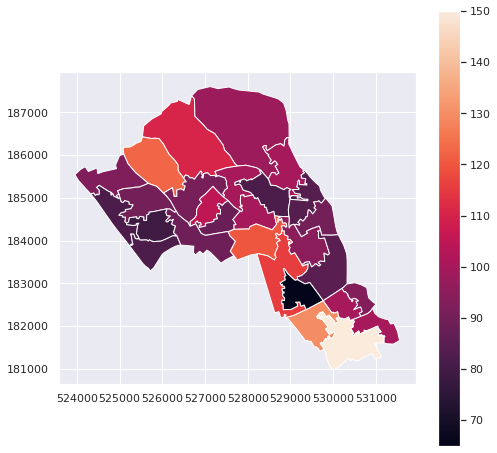

In [191]:
msoa_gdf = msoa_gdf.set_geometry('geometry')
msoa_gdf.plot(column='median', legend=True, figsize=(8,8));

#### 6.5. Create at Atlas-Type Output

In [192]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
# Set 'title font' (tfont) to use in the output 

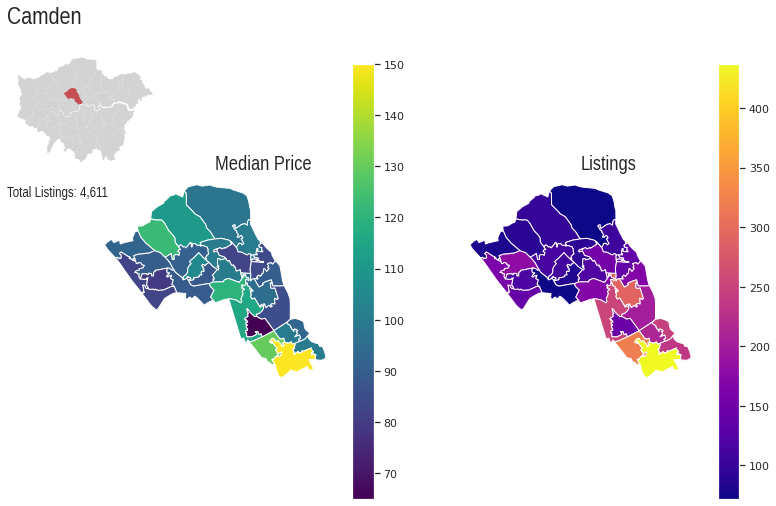

In [193]:
f,axes = plt.subplots(1,2,figsize=(12,8))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

In [ ]:
# msoaculin  = gpd.sjoin(
#             gdf_culin[gdf_culin.BOROUGH==LA].reset_index(), 
#             msoas[msoas.Borough==LA], op='within')
# msoaculin.head()

In [ ]:
# msoaculin_gdf = msoaculin.set_index('MSOA11NM').join(
#                 msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
#                 rsuffix='_r')
# msoaculin_gdf.head()


In [ ]:
# msoaculin_gdf = msoaculin_gdf.set_geometry('geometry_r')
# msoaculin_gdf.plot(column='os_addressbase_uprn', legend=True, figsize=(8,8));

In [ ]:
# f,axes = plt.subplots(1,2,figsize=(12,8))

# msoaculin_gdf.plot(column='easting', ax=axes[0], legend=True, cmap='viridis')
# msoaculin_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
# for ax in axes:
#     ax.axis('off')
    
# ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
# boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
# boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
# ax2.axis('off')

# f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
# axes[0].set_title('Median Price', size=20, **tfont)
# axes[1].set_title('Listings', size=20, **tfont)

# plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

### 7. Hotel Data

#### 7.1. 

In [229]:
url = 'https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/Nomis_accommodation_data.csv'
# Accomodation data source link:
# https://www.nomisweb.co.uk/
    
df_hotel = pd.read_csv(url, low_memory=False)
df_hotel.shape

(28, 40)

In [227]:
to_drop = ['DATE_NAME','DATE_CODE','DATE_TYPE','DATE_TYPECODE','DATE_SORTORDER',
          'DATE_SORTORDER', 'INDUSTRY_CODE', 'INDUSTRY_TYPE', 'INDUSTRY_TYPECODE',
          'INDUSTRY_SORTORDER', 'TURNOVER_SIZEBAND', 'TURNOVER_SIZEBAND_NAME', 
           'TURNOVER_SIZEBAND_CODE']
df_hotel.drop(columns=to_drop, inplace=True)
df_hotel.shape
df_hotel.head()

,DATE,GEOGRAPHY,GEOGRAPHY_NAME,GEOGRAPHY_CODE,GEOGRAPHY_TYPE,GEOGRAPHY_TYPECODE,GEOGRAPHY_SORTORDER,INDUSTRY,INDUSTRY_NAME,TURNOVER_SIZEBAND_TYPE,...,MEASURES,MEASURES_NAME,OBS_VALUE,OBS_STATUS,OBS_STATUS_NAME,OBS_CONF,OBS_CONF_NAME,URN,RECORD_OFFSET,RECORD_COUNT
0,2021,1245708449,Camden 001,E02000166,2011 super output areas - middle layer,297,0,146800695,55 : Accommodation,turnover sizeband,...,20100,Value,0,A,Normal Value,F,Free (free for publication),Nm-199d1d32336e0d1245708449d146800695d0d0d20100,0,28
1,2021,1245708450,Camden 002,E02000167,2011 super output areas - middle layer,297,1,146800695,55 : Accommodation,turnover sizeband,...,20100,Value,5,A,Normal Value,F,Free (free for publication),Nm-199d1d32336e0d1245708450d146800695d0d0d20100,1,28
2,2021,1245708451,Camden 003,E02000168,2011 super output areas - middle layer,297,2,146800695,55 : Accommodation,turnover sizeband,...,20100,Value,5,A,Normal Value,F,Free (free for publication),Nm-199d1d32336e0d1245708451d146800695d0d0d20100,2,28
3,2021,1245708452,Camden 004,E02000169,2011 super output areas - middle layer,297,3,146800695,55 : Accommodation,turnover sizeband,...,20100,Value,5,A,Normal Value,F,Free (free for publication),Nm-199d1d32336e0d1245708452d146800695d0d0d20100,3,28
4,2021,1245708453,Camden 005,E02000170,2011 super output areas - middle layer,297,4,146800695,55 : Accommodation,turnover sizeband,...,20100,Value,0,A,Normal Value,F,Free (free for publication),Nm-199d1d32336e0d1245708453d146800695d0d0d20100,4,28


In [ ]:
gdf_hotel = gpd.GeoDataFrame(df_hotel, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude,
                                                       crs='epsg:4326'))
gdf_hotel = gdf_hotel.to_crs('epsg:27700')

In [ ]:
msoahotel  = gpd.sjoin(
            gdf_culin[gdf_culin.BOROUGH==LA].reset_index(), 
            msoas[msoas.Borough==LA], op='within')
msoahotel.head()